# Project IRWA

Estellers, Oriol - 242142

Fuentes, Raimon - 242176
  
Ribas, Pol - 241620

## Part 1

### Packages and imports

In [1]:
!pip install spacy

In [2]:
!python -m spacy download en_core_web_sm

2023-11-14 18:03:13.035765: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 18:03:13.035832: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 18:03:13.035875: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 18:03:13.047886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 18:03:14.894640: W tensorflow/compiler/

In [3]:
!pip install num2words

In [4]:
!pip install clean-text

In [5]:
!pip install wordcloud

In [6]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
import os
from numpy import linalg as la
import pandas as pd
import re
from num2words import num2words
import string
from cleantext import clean
import emoji
import regex
from nltk.tokenize import TweetTokenizer
from collections import Counter
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
import spacy
from collections import Counter
import time
from google.colab import drive
from nltk.draw.util import Text
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
import re
from sklearn import preprocessing
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Data to memory

In [7]:
df = pd.read_json('https://raw.githubusercontent.com/Oriesdo/IRWA-2023-242142-241620-242176/main/IRWA_data_2023/Rus_Ukr_war_data.json', lines = True)
print("Total number of Tweets in the corpus: {}".format(len(df)))

drive.mount('/content/drive')
%cd /content/drive/Shareddrives/RIAW/Project/
df_ids=pd.read_csv('IRWA_data_2023/Rus_Ukr_war_data_ids.csv', sep='\t', header = None)
df_ids.columns = ['doc_num', 'id']

df_merged = pd.merge(df_ids, df, on='id', how='inner')

Total number of Tweets in the corpus: 4000
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/RIAW/Project


### Pre-processing of documents

In [8]:
def build_terms(line):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.

    Argument:
    line -- string (text) to be preprocessed

    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    ## START CODE
    line = line.lower() # transform text to lowercase
    line = re.sub(r'[!"$%&()*+,-./:;<=>?[\]^_`{|}~]', '', line) # remove punctuation marks
    tokenizer = TweetTokenizer()
    line = tokenizer.tokenize(line) # tokenize the text to get a list of terms
    line = [x for x in line if x not in stop_words]  # eliminate the stopwords
    line = [stemmer.stem(word) for word in line] # perform stemming
    line = [re.sub(r'\d+', lambda match: num2words( match.group(0), to = 'cardinal' ), word) for word in line] # convert nums to cardinal words
    line = [clean(word, no_emoji=True) for word in line] # delete emojis

    return line

### Exploratory Data Analysis

In [9]:
# creating column with the normalized tweets
norm = []
for i in range(len(df_merged)):
  norm.append(build_terms(df_merged.iloc[i]['full_text']))

df_merged['normalized'] = norm

In [10]:
# AVERAGE NUMBER OF WORDS PER TWEET

norm = []
num_words = []
for i in range(len(df_merged)): # loop to iterate through all the tweets
  tweet = []
  for word in df_merged.iloc[i]['normalized']:
    tweet.append(word)
    num_words.append(len(tweet)) # we store the length of the tweet
  norm.append(' '.join(tweet))
avg_words = np.average(num_words) # computing the average
std_dev = np.std(num_words) # computing the standard deviation
print("The average number of words per tweet is", round(avg_words,2))
print("With a standard deviation of", round(std_dev,2))


df_merged['normalized_full_tweet'] = norm

The average number of words per tweet is 11.68
With a standard deviation of 7.55


In [11]:
# TOP-5 HASHTAGS


hashtag_dict = {} # dictionary to store the occurences of all hashtags
for k in range(len(df_merged)): # iterate through all tweets
  line = df_merged.iloc[k]['normalized_full_tweet']
  for i in range(len(line)): # iterate through each letter of the tweet
    if line[i] == '#': # if it is a hashtag
      hashtag = ''
      j = i
      while j < len(line) and line[j] != ' ': # loop to iterate through all the letters after the hashtag
        hashtag += line[j]
        j += 1
      if hashtag in hashtag_dict: # checking if that hashtag is already in the dictionary
        hashtag_dict[hashtag] += 1
      else: # if not, we add it
        hashtag_dict[hashtag] = 1
res = dict(sorted(hashtag_dict.items(), key = lambda x: x[1], reverse = True)[:5]) # get the top-5 most used hashtags
print("The top 5 hashtags used are  " + str(res))

The top 5 hashtags used are  {'#ukrainerussiawar': 4012, '#ukrain': 2163, '#ukrainewar': 1326, '#russia': 1232, '#russian': 724}


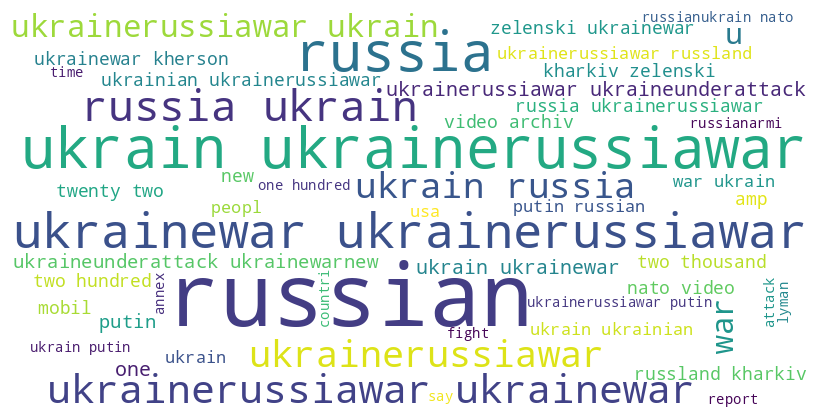

In [12]:
# TOP-50 MOST USED WORDS WITH WORD CLOUD


all_tweets_together = " ".join(df_merged.iloc[:]['normalized_full_tweet']) # we put all the normalized tweets into a single sentence

words_without_http = ' '.join(word for word in all_tweets_together.split() if not word.startswith('http')) # we remove the words starting with 'http'

wordcloud = WordCloud(width=800, height=400, # generating the word cloud
                      background_color='white',
                      min_font_size=10,
                      max_words=50).generate(words_without_http)

plt.figure(figsize=(8, 8), facecolor=None) # display the word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

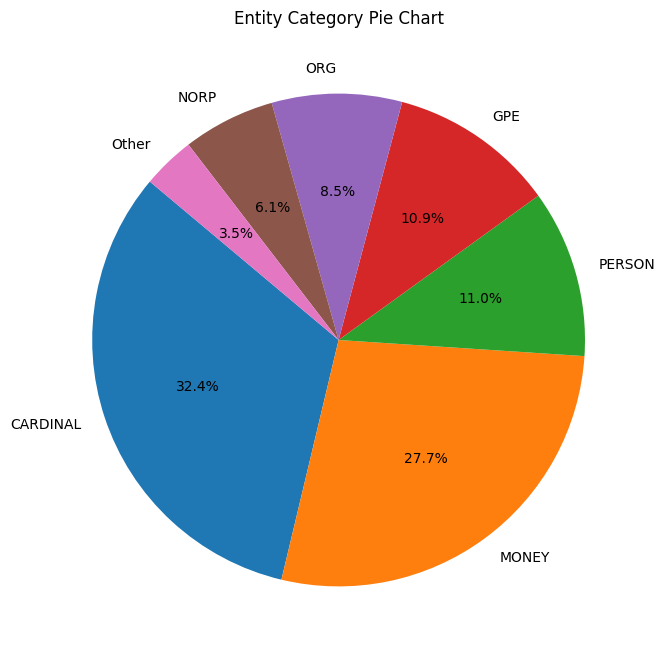

In [13]:
# ENTITY RECOGNITION


nlp = spacy.load('en_core_web_sm') # load the English language model

text = " ".join(df_merged.iloc[:]['normalized_full_tweet'])
doc = nlp(text)
entity_counter = Counter(ent.label_ for ent in doc.ents)  # extract and count named entities

sorted_entities = sorted(entity_counter.items(), key=lambda x: x[1], reverse=True) # sort increasingly

# we will group the entities with less than 6% into the category "the"
threshold = 6  # set the threshold percentage
total_count = sum(entity_counter.values())
other_count = sum(count for label, count in sorted_entities if (count / total_count) < threshold / 100)

# filter entities that belong to the <6% group
filtered_entities = [(label, count) for label, count in sorted_entities if (count / total_count) >= threshold / 100]

filtered_entities.append(('Other', other_count)) # add "Other" category to the entities

entity_labels, entity_counts = zip(*filtered_entities)

plt.figure(figsize=(8, 8)) # create pie chart
plt.pie(entity_counts, labels=entity_labels, autopct='%1.1f%%', startangle=140)
plt.title("Entity Category Pie Chart")
plt.show()

In [14]:
# VOCABULARY SIZE


unique_vocab = {} # dictionary to store all the unique words
for k in range(len(df)): # we iterate through all the tweets
  line = df_merged.iloc[k]['normalized_full_tweet'].split(" ") # we split the tweet by words
  for word in line:
    if word in unique_vocab: # checking if the word is in the dictionary
      unique_vocab[word] +=1
    else: # if not we add them
      unique_vocab[word] = 1
print("The vocabulary size of the normalized tweets is", len(unique_vocab))
print("The average number of unique words per tweet is", round(len(unique_vocab)/len(df), 2))
print("The percentage of unique words per each tweet is", round(((len(unique_vocab)/len(df))/(round(avg_words,2)))*100, 2),"%")

The vocabulary size of the normalized tweets is 13581
The average number of unique words per tweet is 3.4
The percentage of unique words per each tweet is 29.07 %


In [15]:
# HISTOGRAM OF EMOJIS USED


# these are the codes of the list of emojis that we will look for
emoji_pattern = re.compile(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001F004-\U0001F0CF\U0001F170-\U0001F251]')
sentences_with_emojis = [] # list to store the sentences that contain emojis

for i in range(len(df)): # we iterate through all the tweets so as to store the ones that contain emojis
  tweet = df.iloc[i]['full_text']
  tweet = tweet.split('https')
  if re.search(emoji_pattern,tweet[0]):
      sentences_with_emojis.append(tweet[0])

text = ' '.join(sentences_with_emojis) # we create one single text with all the tweets containing emojis

emojis = emoji_pattern.findall(text) # look for all the emojis in the text

emoji_counts = Counter(emojis) # count the occurrences of each emoji

sorted_emoji_counts = dict(sorted(emoji_counts.items(), key=lambda item: item[1], reverse=True)[:25]) # we will only pick the top 25 most used ones
emoji_df = pd.DataFrame(list(sorted_emoji_counts.items()), columns=['Emoji', 'Count']) # create a DataFrame

fig = px.histogram(emoji_df, x='Emoji', y='Count', title='Emoji Occurrences Histogram') # histogram with Plotly Express
fig.update_layout(xaxis_title='', showlegend=False)
fig.update_traces(marker_color='blue', selector=dict(type='bar'))

fig.update_traces(text=emoji_df['Count'].astype(str) + ' occurrences of ' + emoji_df['Emoji'])
fig.update_traces(textposition='outside')
fig.update_layout(hovermode='x unified')

# Show the interactive histogram
fig.show()

In [16]:
# TOP-5 MOST MENTIONED COUNTRIES


countries = [
    "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda",
    "Argentina", "Armenia", "Australia", "Austria", "Azerbaijan", "Bahamas",
    "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin",
    "Bhutan", "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei",
    "Bulgaria", "Burkina Faso", "Burundi", "Cabo Verde", "Cambodia", "Cameroon",
    "Canada", "Central African Republic", "Chad", "Chile", "China", "Colombia",
    "Comoros", "Congo", "Costa Rica", "Cote d'Ivoire", "Croatia", "Cuba", "Cyprus",
    "Czechia", "Denmark", "Djibouti", "Dominica", "Dominican Republic", "Ecuador",
    "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini",
    "Ethiopia", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany",
    "Ghana", "Greece", "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana",
    "Haiti", "Honduras", "Hungary", "Iceland", "India", "Indonesia", "Iran", "Iraq",
    "Ireland", "Israel", "Italy", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya",
    "Kiribati", "Korea, North", "Korea, South", "Kosovo", "Kuwait", "Kyrgyzstan",
    "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia", "Libya", "Liechtenstein",
    "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives",
    "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico",
    "Micronesia", "Moldova", "Monaco", "Mongolia", "Montenegro", "Morocco",
    "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal", "Netherlands",
    "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Macedonia", "Norway",
    "Oman", "Pakistan", "Palau", "Palestine", "Panama", "Papua New Guinea",
    "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Qatar", "Romania",
    "Russia", "Rwanda", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines",
    "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal",
    "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia",
    "Solomon Islands", "Somalia", "South Africa", "South Sudan", "Spain", "Sri Lanka",
    "Sudan", "Suriname", "Sweden", "Switzerland", "Syria", "Taiwan", "Tajikistan",
    "Tanzania", "Thailand", "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago",
    "Tunisia", "Turkey", "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates",
    "United Kingdom", "United States", "Uruguay", "Uzbekistan", "Vanuatu", "Vatican City",
    "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"
]

countries_dict = {} # dictionary to store all the countries appearing
for i in range(len(df)): # loop to iterate through all the tweets
  line = df.iloc[i]['full_text']
  s=line.split(" ") # we split the tweets in words
  for w in s: # we iterate for each word in the sentence
    if w in countries: # if the word is a country
      if w in countries_dict: # we check if the country is already stored in the dictionary
        countries_dict[w] += 1
      else: # if not we add them
        countries_dict[w] = 1
res = dict(sorted(countries_dict.items(), key = lambda x: x[1], reverse = True)[:5]) # we get the top-5 countries
print("The top 5 countries used are  " + str(res))

The top 5 countries used are  {'Ukraine': 537, 'Russia': 323, 'Germany': 25, 'Belarus': 22, 'Finland': 13}


In [17]:
# TOP-5 MOST ACTIVE USERS


tweets_by={} # dictionary to store the users that tweet
for k in range(len(df)): # iterate through all the tweets
  line = df_merged.iloc[k]['normalized_full_tweet']
  for i in range(len(line)): # iterate through all the letters
    if line[i] == '@': # if a user appears
      arr = ''
      j = i
      while j < len(line) and line[j] != ' ': # we iterate through the remaining words to get the name
        arr += line[j]
        j += 1
      if arr in tweets_by: # checking if the user is already in the dictionary
        tweets_by[arr] += 1
      else: # if not we add them
        tweets_by[arr] = 1
res = dict(sorted(tweets_by.items(), key = lambda x: x[1], reverse = True)[:5]) # get the top-5 users that have posted the most
print("The top 5 most active users are  " + str(res))

The top 5 most active users are  {'@zelenskyyua': 44, '@youtub': 40, '@potu': 31, '@eucommiss': 22, '@mfarussia': 22}


## Part 2

In [18]:
#now we also remove # and @ when doing the pre-processing of the tweets

def build_terms(line):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.

    Argument:
    line -- string (text) to be preprocessed

    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    ## START CODE
    line = line.lower() # transform text to lowercase
    line = re.sub(r'[!"$%&()@#*+,-./:;<=>?[\]^_`{|}~]', '', line) # remove punctuation marks
    tokenizer = TweetTokenizer()
    line = tokenizer.tokenize(line) # tokenize the text to get a list of terms
    line = [x for x in line if x not in stop_words]  # eliminate the stopwords
    line = [stemmer.stem(word) for word in line] # perform stemming
    line = [re.sub(r'\d+', lambda match: num2words( match.group(0), to = 'cardinal' ), word) for word in line] # convert nums to cardinal words
    line = [clean(word, no_emoji=True) for word in line] # delete emojis

    return line

In [19]:
# creating column with the normalized tweets
norm = []
for i in range(len(df_merged)):
  norm.append(build_terms(df_merged.iloc[i]['full_text']))

df_merged['really_normalized'] = norm

### Indexing

In [20]:
def create_index(lines):
    """
    Implement the inverted index

    Argument:
    lines -- collection of Wikipedia articles

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    """

    index = defaultdict(list)
    tweet_index = {}  # dictionary to map page titles to page ids
    for i in range(len(lines)):  # Remember, lines contain all documents: article-id | article-title | article-body

        terms = build_terms(lines.iloc[i]['full_text']) # page_title + page_text
        tweet_index[lines.iloc[i]['id']] = lines.iloc[i]['id']

        current_tweet_index = {}

        for position, term in enumerate(terms): # terms contains page_title + page_text. Loop over all terms
            try:

                current_tweet_index[term][1].append(position)
            except:
                current_tweet_index[term]=[lines.iloc[i]['id'], array('I',[position])] #'I' indicates unsigned int (int in Python)

        for term_page, posting_page in current_tweet_index.items():
            index[term_page].append(posting_page)


    return index, tweet_index

In [21]:
'''
import time
start_time = time.time()
index, tweet_index = create_index(df_merged[['id','full_text']].copy())
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))
'''

'\nimport time\nstart_time = time.time()\nindex, tweet_index = create_index(df_merged[[\'id\',\'full_text\']].copy())\nprint("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))\n'

In [22]:
def search(query, index):
    """
    The output is the list of documents that contain any of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
    ## START DODE
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs=[posting[0] for posting in index[term]]
            # docs = docs Union term_docs
            docs |= set(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    if len(docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search(query, index)
    return docs

In [23]:
'''
print("Insert your query (i.e.: Computer Science):\n")
query = input()
docs = search(query, index)
top = 10

print("\n======================\nSample of {} results out of {} for the searched query:\n".format(min(top, len(docs)), len(docs)))

for d_id in docs[:top]:
  print("Document number is", [(df_merged['doc_num'][i]) for i in range(len(df)) if df_merged['id'][i] == d_id])
  print("and the tweet is", [(df_merged['full_text'][i]) for i in range(len(df)) if df_merged['id'][i] == d_id])
'''

'\nprint("Insert your query (i.e.: Computer Science):\n")\nquery = input()\ndocs = search(query, index)\ntop = 10\n\nprint("\n======================\nSample of {} results out of {} for the searched query:\n".format(min(top, len(docs)), len(docs)))\n\nfor d_id in docs[:top]:\n  print("Document number is", [(df_merged[\'doc_num\'][i]) for i in range(len(df)) if df_merged[\'id\'][i] == d_id])\n  print("and the tweet is", [(df_merged[\'full_text\'][i]) for i in range(len(df)) if df_merged[\'id\'][i] == d_id])\n'

In [24]:
def create_index_tfidf(lines, num_documents):
    """
    Implement the inverted index and compute tf, df and idf

    Argument:
    lines -- collection of Wikipedia articles
    num_documents -- total number of documents

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  # document frequencies of terms in the corpus
    idf = defaultdict(float)
    title_index = defaultdict(str)

    for i in range(len(lines)):  # Remember, lines contain all documents: article-id | article-title | article-body

        terms = build_terms(lines.iloc[i]['full_text']) # page_title + page_text
        tweet_index[lines.iloc[i]['id']] = lines.iloc[i]['id']

        ## ===============================================================
        ## create the index for the **current page** and store it in current_page_index
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0,
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_tweet_index = {}

        for position, term in enumerate(terms):  ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_tweet_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_tweet_index[term]=[lines.iloc[i]['id'], array('I',[position])] #'I' indicates unsigned int (int in Python)


        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_tweet_index.items():
            # posting will contain the list of positions for current term in current document.
            # posting ==> [current_doc, [list of positions]]
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        # calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_tweet_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_tweet_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4)

    return index, tf, df, idf

In [25]:
'''
start_time = time.time()
num_documents = len(df_merged)
index, tf, df, idf = create_index_tfidf(df_merged[['id','full_text']].copy(), num_documents)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))
'''

'\nstart_time = time.time()\nnum_documents = len(df_merged)\nindex, tf, df, idf = create_index_tfidf(df_merged[[\'id\',\'full_text\']].copy(), num_documents)\nprint("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))\n'

In [26]:
def rank_documents(terms, docs, index, idf, tf, tweet_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title

    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    # HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc
    # compute the cosine similarity between queryVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot

    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        result_docs, doc_scores = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs, doc_scores

In [27]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs=[posting[0] for posting in index[term]]

            # docs = docs Union term_docs
            docs |= set(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs, scores = rank_documents(query, docs, index, idf, tf, tweet_index)
    return ranked_docs, scores

In [28]:
df_merged_copy = df_merged.copy()
'''print("Insert your query (i.e.: Computer Science):\n")
query = input()
ranked_docs, doc_scores = search_tf_idf(query, index)

print(len(doc_scores))

top = 10

print("\n======================\nSample of {} results out of {} for the searched query:\n".format(min(top, len(ranked_docs)), len(ranked_docs)))

for d_id in ranked_docs[:top]:

  for i in range(len(df_merged_copy)):
        if df_merged_copy['id'][i] == d_id:
            print("doc_num = {} and the tweet is = {}".format(df_merged_copy['doc_num'][i], df_merged_copy['full_text'][i]))'''

'print("Insert your query (i.e.: Computer Science):\n")\nquery = input()\nranked_docs, doc_scores = search_tf_idf(query, index)\n\nprint(len(doc_scores))\n\ntop = 10\n\nprint("\n======================\nSample of {} results out of {} for the searched query:\n".format(min(top, len(ranked_docs)), len(ranked_docs)))\n\nfor d_id in ranked_docs[:top]:\n\n  for i in range(len(df_merged_copy)):\n        if df_merged_copy[\'id\'][i] == d_id:\n            print("doc_num = {} and the tweet is = {}".format(df_merged_copy[\'doc_num\'][i], df_merged_copy[\'full_text\'][i]))'

###Evaluation



In [29]:
df_evaluation=pd.read_csv('Evaluation_gt.csv') #we create a dataframe with the prediction scores of each of the documents
df_evaluation['predicted_scores_q1'] = [0]*60  #we create a column for each of the queries
df_evaluation['predicted_scores_q2'] = [0]*60
df_evaluation['predicted_scores_q3'] = [0]*60
df_evaluation['label_q1'] = [0]*60
df_evaluation['label_q2'] = [0]*60
df_evaluation['label_q3'] = [0]*60

In [30]:
for i in range(len(df_evaluation)): # we keep the 0 if it is not a relevant doc for the query
  if df_evaluation['query_id'][i] == "Q1":
    df_evaluation['label_q1'][i] = df_evaluation['label'][i]
  elif df_evaluation['query_id'][i] == "Q2":
    df_evaluation['label_q2'][i] = df_evaluation['label'][i]
  else:
    df_evaluation['label_q3'][i] = df_evaluation['label'][i]

<ipython-input-30-97fdd5854eda>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-30-97fdd5854eda>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-30-97fdd5854eda>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
def precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1]  #we sort the predictions by  score
    doc_score = np.take(doc_score, order[:k]) #y_true    we take the k most relevant that we predicted from the ground truth list
    relevant = sum(doc_score==1)  # we sum the relevant documents that were in our prediction as well
    return float(relevant)/k #we return the sum divided by k

def recall_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k: Number of documents to consider.

    Returns
    -------
    recall @k: float

    """
    order = np.argsort(y_score)[::-1] #we sort the predictions by  score
    doc_score = np.take(doc_score, order[:k])  # y_true   we take the k most relevant that we predicted from the ground truth list
    relevant = sum(doc_score == 1)# we sum the relevant documents that were in our prediction as well
    total_relevant = sum(doc_score) #we sum to get the total number of relevant documents

    return float(relevant)/total_relevant # we return the division between relevant and total relevant

def avg_precision_at_k(doc_score, y_score, query_label ,k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    query_label: a label for the query we'll be performing
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(doc_score==1)  # we get the total number of relevant documents
    order = np.argsort(y_score)[::-1]  #sort our predicted docs by most relevant
    doc_score = np.take(doc_score, order[:k]) #y_true  we take the k most relevant that we predicted from the ground truth list
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0

    score_df = pd.DataFrame(doc_score)
    score_df = score_df.reset_index(drop=True) #we reset the indexes

    for i in range(k): #for every prediction
        if score_df[query_label][i] == 1:
            n_relevant_at_i += 1 #we sum in the relevant counter
            prec_at_i += n_relevant_at_i/(i+1) #we sum in the formula
    return prec_at_i/gtp


def map_at_k(queries_labels, search_res, k=10):
    """
    Parameters
    ----------
     queries_labels: labels for each query we'll be performing
     search_res: matrix with the following components
        doc_score (even positions): Ground truth (true relevance labels).
        y_score (odd positions): Predicted scores.
     k: number of doc to consider.


    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    q_id = 0
    for q in queries_labels:
        doc_score = search_res[q_id]
        y_score = search_res[q_id+1]
        q_id += 2

        value = avg_precision_at_k(doc_score, y_score, q, k=10)
        avp.append(value)  #append average precision for current query
    return sum(avp)/len(avp), avp  # return mean average precision


def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """

    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k]) #y_true

    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1/(np.argmax(doc_score==1)+1)  # hint: to get the position of the first relevant document use "np.argmax"


def mrr_at_k(queries_labels, search_res, k=10):
    """
    Parameters
    ----------
    queries_labels: labels for each query we'll be performing
    search_res: matrix with the following components
        doc_score (even positions): Ground truth (true relevance labels).
        y_score (odd positions): Predicted scores.
    k: number of doc to consider.


    Returns
    -------
    mean reciprocal rank @ k : float
    """
    avp = []
    q_id = 0
    for q in queries_labels:
        doc_score = search_res[q_id]
        y_score = search_res[q_id+1]
        q_id += 2

        value = rr_at_k(doc_score, y_score, k=10)
        avp.append(value)  #append average precision for current query
    return sum(avp)/len(avp), avp  # return mean average precision


def dcg_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    dcg for qurrent query
    """

    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k]) #y_true
    gain = 2** doc_score-1  # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(doc_score))+2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    ndcg for qurrent query
    """

    dcg_max = dcg_at_k(doc_score, doc_score, k=10) # Ideal dcg
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k=10)/dcg_max, 4) # return ndcg@k

def mndcg(queries_labels, search_res, k=10):
    """
    Parameters
    ----------
    queries_labels: labels for each query we'll be performing
    search_res: matrix with the following components
        doc_score (even positions): Ground truth (true relevance labels).
        y_score (odd positions): Predicted scores.
    k: number of doc to consider.


    Returns
    -------
    mean normalized discounted cumulative gain @ k : float
    """
    avp = []
    q_id = 0
    for q in queries_labels:
        doc_score = search_res[q_id]
        y_score = search_res[q_id+1]
        q_id += 2

        value = ndcg_at_k(doc_score, y_score, k=10)
        avp.append(value)  #append average precision for current query
    return sum(avp)/len(avp), avp  # return mean average precision

def f1_at_k(doc_score, y_score, k=10):
  rec = recall_at_k(doc_score, y_score, k=10) #calculate the recall with the function
  prec = precision_at_k(doc_score, y_score, k=10) #calculate the precision with the function
  f1 = 2*(prec*rec)/(prec+rec) #apply the formula
  return f1

In [32]:
'''
#for each of the queries

#check for query 1
Q1 = build_terms("tank in Kharkiv")
Q1 = ' '.join(Q1)
ranked_docs, doc_scores = search_tf_idf(Q1, index) #calculate the most relevant (prediction with the algorithm implemented earlier)
for i in range(len(doc_scores)):
  for j in range(len(df_merged_copy)):
    if df_merged_copy['id'][j] == doc_scores[i][1]:  #if the tweet is relevant
      doc_num = df_merged_copy['doc_num'][j] #get the doc num
      for m in range(len(df_evaluation)):
        if df_evaluation['doc'][m] == doc_num:
          df_evaluation['predicted_scores_q1'][m] = doc_scores[i][0] #we add it to the table

#check for query 2
Q2 = build_terms("Nord Stream pipeline")
Q2 = ' '.join(Q2)
ranked_docs, doc_scores = search_tf_idf(Q2, index)
for i in range(len(doc_scores)):
  for j in range(len(df_merged_copy)):
    if df_merged_copy['id'][j] == doc_scores[i][1]:
      doc_num = df_merged_copy['doc_num'][j]
      for m in range(len(df_evaluation)):
        if df_evaluation['doc'][m] == doc_num:
          df_evaluation['predicted_scores_q2'][m] = doc_scores[i][0]


#check for query 3
Q3 = build_terms("annexion of territories by Russia")
Q3 = ' '.join(Q3)
ranked_docs, doc_scores = search_tf_idf(Q3, index)
for i in range(len(doc_scores)):
  for j in range(len(df_merged_copy)):
    if df_merged_copy['id'][j] == doc_scores[i][1]:
      doc_num = df_merged_copy['doc_num'][j]
      for m in range(len(df_evaluation)):
        if df_evaluation['doc'][m] == doc_num:
          df_evaluation['predicted_scores_q3'][m] = doc_scores[i][0]
'''

'\n#for each of the queries\n\n#check for query 1\nQ1 = build_terms("tank in Kharkiv")\nQ1 = \' \'.join(Q1)\nranked_docs, doc_scores = search_tf_idf(Q1, index) #calculate the most relevant (prediction with the algorithm implemented earlier)\nfor i in range(len(doc_scores)):\n  for j in range(len(df_merged_copy)):\n    if df_merged_copy[\'id\'][j] == doc_scores[i][1]:  #if the tweet is relevant\n      doc_num = df_merged_copy[\'doc_num\'][j] #get the doc num\n      for m in range(len(df_evaluation)):\n        if df_evaluation[\'doc\'][m] == doc_num:\n          df_evaluation[\'predicted_scores_q1\'][m] = doc_scores[i][0] #we add it to the table\n\n#check for query 2\nQ2 = build_terms("Nord Stream pipeline")\nQ2 = \' \'.join(Q2)\nranked_docs, doc_scores = search_tf_idf(Q2, index)\nfor i in range(len(doc_scores)):\n  for j in range(len(df_merged_copy)):\n    if df_merged_copy[\'id\'][j] == doc_scores[i][1]:\n      doc_num = df_merged_copy[\'doc_num\'][j]\n      for m in range(len(df_evalua

In [33]:
'''
df_evaluation_copy = df_evaluation.copy()
indices_to_drop = []
for i in range(len(df_evaluation_copy)):    #get the relevant documents of the query
  if df_evaluation_copy['label'][i] != 1:
    if df_evaluation_copy['query_id'][i] != "Q1":
      indices_to_drop.append(i)
df_q1 = df_evaluation_copy.drop(indices_to_drop)
df_q1 = df_q1.reset_index(drop=True)
#we get the prediction and the ground truth and call the evaluation functions for each of the queries
ground_truth_1 = df_q1['label_q1']
predicted_scores_1 = df_q1['predicted_scores_q1']

print("Precision for Q1:", precision_at_k(ground_truth_1, predicted_scores_1, k=10))
print("Recall for Q1:", recall_at_k(ground_truth_1, predicted_scores_1, k=10))
print("F1 at k for Q1:", f1_at_k(ground_truth_1, predicted_scores_1, k=10))
print("Average precision for Q1:", avg_precision_at_k(ground_truth_1, predicted_scores_1,'label_q1', k=10 ))
print("Reciprocal rank for Q1:", rr_at_k(ground_truth_1, predicted_scores_1, k=10))
print("Normalized Discounted Cumulative Gain for Q1:", ndcg_at_k(ground_truth_1, predicted_scores_1, k=10))
'''

'\ndf_evaluation_copy = df_evaluation.copy()\nindices_to_drop = []\nfor i in range(len(df_evaluation_copy)):    #get the relevant documents of the query\n  if df_evaluation_copy[\'label\'][i] != 1:\n    if df_evaluation_copy[\'query_id\'][i] != "Q1":\n      indices_to_drop.append(i)\ndf_q1 = df_evaluation_copy.drop(indices_to_drop)\ndf_q1 = df_q1.reset_index(drop=True)\n#we get the prediction and the ground truth and call the evaluation functions for each of the queries\nground_truth_1 = df_q1[\'label_q1\']\npredicted_scores_1 = df_q1[\'predicted_scores_q1\']\n\nprint("Precision for Q1:", precision_at_k(ground_truth_1, predicted_scores_1, k=10))\nprint("Recall for Q1:", recall_at_k(ground_truth_1, predicted_scores_1, k=10))\nprint("F1 at k for Q1:", f1_at_k(ground_truth_1, predicted_scores_1, k=10))\nprint("Average precision for Q1:", avg_precision_at_k(ground_truth_1, predicted_scores_1,\'label_q1\', k=10 ))\nprint("Reciprocal rank for Q1:", rr_at_k(ground_truth_1, predicted_scores_1,

In [34]:
'''
df_evaluation_copy = df_evaluation.copy()
indices_to_drop = []
for i in range(len(df_evaluation_copy)):
  if df_evaluation_copy['label'][i] != 1:
    if df_evaluation_copy['query_id'][i] != "Q2":
      indices_to_drop.append(i)
df_q2 = df_evaluation_copy.drop(indices_to_drop)
df_q2 = df_q2.reset_index(drop=True)


ground_truth_2 = df_q2['label_q2']
predicted_scores_2 = df_q2['predicted_scores_q2']

print("Precision for Q2:", precision_at_k(ground_truth_2, predicted_scores_2, k=10))
print("Recall for Q2:", recall_at_k(ground_truth_2, predicted_scores_2, k=10))
print("F1 at k for Q2:", f1_at_k(ground_truth_2, predicted_scores_2, k=10))
print("Average precision for Q2:", avg_precision_at_k(ground_truth_2, predicted_scores_2,'label_q2', k=10))
print("Reciprocal rank for Q2:", rr_at_k(ground_truth_2, predicted_scores_2, k=10))
print("Normalized Discounted Cumulative Gain for Q2:", ndcg_at_k(ground_truth_2, predicted_scores_2, k=10))
'''

'\ndf_evaluation_copy = df_evaluation.copy()\nindices_to_drop = []\nfor i in range(len(df_evaluation_copy)):\n  if df_evaluation_copy[\'label\'][i] != 1:\n    if df_evaluation_copy[\'query_id\'][i] != "Q2":\n      indices_to_drop.append(i)\ndf_q2 = df_evaluation_copy.drop(indices_to_drop)\ndf_q2 = df_q2.reset_index(drop=True)\n\n\nground_truth_2 = df_q2[\'label_q2\']\npredicted_scores_2 = df_q2[\'predicted_scores_q2\']\n\nprint("Precision for Q2:", precision_at_k(ground_truth_2, predicted_scores_2, k=10))\nprint("Recall for Q2:", recall_at_k(ground_truth_2, predicted_scores_2, k=10))\nprint("F1 at k for Q2:", f1_at_k(ground_truth_2, predicted_scores_2, k=10))\nprint("Average precision for Q2:", avg_precision_at_k(ground_truth_2, predicted_scores_2,\'label_q2\', k=10))\nprint("Reciprocal rank for Q2:", rr_at_k(ground_truth_2, predicted_scores_2, k=10))\nprint("Normalized Discounted Cumulative Gain for Q2:", ndcg_at_k(ground_truth_2, predicted_scores_2, k=10))\n'

In [35]:
'''
df_evaluation_copy = df_evaluation.copy()
indices_to_drop = []
for i in range(len(df_evaluation_copy)):
  if df_evaluation_copy['label'][i] != 1:
    if df_evaluation_copy['query_id'][i] != "Q3":
      indices_to_drop.append(i)
df_q3 = df_evaluation_copy.drop(indices_to_drop)
df_q3 = df_q3.reset_index(drop=True)

ground_truth_3 = df_q3['label_q3']
predicted_scores_3 = df_q3['predicted_scores_q3']

print("Precision for Q3:", precision_at_k(ground_truth_3, predicted_scores_3, k=10))
print("Recall for Q3:", recall_at_k(ground_truth_3, predicted_scores_3, k=10))
print("F1 at k for Q3:", f1_at_k(ground_truth_3, predicted_scores_3, k=10))
print("Average precision for Q3:", avg_precision_at_k(ground_truth_3, predicted_scores_3,'label_q3', k=10))
print("Reciprocal rank for Q3:", rr_at_k(ground_truth_3, predicted_scores_3, k=10))
print("Normalized Discounted Cumulative Gain for Q3:", ndcg_at_k(ground_truth_3, predicted_scores_3, k=10))
'''

'\ndf_evaluation_copy = df_evaluation.copy()\nindices_to_drop = []\nfor i in range(len(df_evaluation_copy)):\n  if df_evaluation_copy[\'label\'][i] != 1:\n    if df_evaluation_copy[\'query_id\'][i] != "Q3":\n      indices_to_drop.append(i)\ndf_q3 = df_evaluation_copy.drop(indices_to_drop)\ndf_q3 = df_q3.reset_index(drop=True)\n\nground_truth_3 = df_q3[\'label_q3\']\npredicted_scores_3 = df_q3[\'predicted_scores_q3\']\n\nprint("Precision for Q3:", precision_at_k(ground_truth_3, predicted_scores_3, k=10))\nprint("Recall for Q3:", recall_at_k(ground_truth_3, predicted_scores_3, k=10))\nprint("F1 at k for Q3:", f1_at_k(ground_truth_3, predicted_scores_3, k=10))\nprint("Average precision for Q3:", avg_precision_at_k(ground_truth_3, predicted_scores_3,\'label_q3\', k=10))\nprint("Reciprocal rank for Q3:", rr_at_k(ground_truth_3, predicted_scores_3, k=10))\nprint("Normalized Discounted Cumulative Gain for Q3:", ndcg_at_k(ground_truth_3, predicted_scores_3, k=10))\n'

In [36]:
'''
matrix=[ground_truth_1, predicted_scores_1, ground_truth_2, predicted_scores_2, ground_truth_3, predicted_scores_3]
print("The mean averagre precision is", map_at_k(['label_q1', 'label_q2', 'label_q3'], matrix, k=10))
print("The mean reciprocal rank is", mrr_at_k(['label_q1', 'label_q2', 'label_q3'], matrix, k=10))
print("The mean normalized discounted cumulative gain is", mndcg(['label_q1', 'label_q2', 'label_q3'], matrix, k=10))
'''

'\nmatrix=[ground_truth_1, predicted_scores_1, ground_truth_2, predicted_scores_2, ground_truth_3, predicted_scores_3]\nprint("The mean averagre precision is", map_at_k([\'label_q1\', \'label_q2\', \'label_q3\'], matrix, k=10))\nprint("The mean reciprocal rank is", mrr_at_k([\'label_q1\', \'label_q2\', \'label_q3\'], matrix, k=10))\nprint("The mean normalized discounted cumulative gain is", mndcg([\'label_q1\', \'label_q2\', \'label_q3\'], matrix, k=10))\n'

In [37]:
'''
Q1 = build_terms("Mykolaiv explosion bus station")
Q1 = ' '.join(Q1)


ranked_docs, doc_scores = search_tf_idf(Q1, index)

top = 10

print("\n======================\nSample of {} results out of {} for the query '{}':\n".format(min(top, len(ranked_docs)), len(ranked_docs), Q1))

for d_id in ranked_docs[:top]:
  for i in range(len(df_merged_copy)):
        if df_merged_copy['id'][i] == d_id:
            print("doc_num = {} ".format(df_merged_copy['doc_num'][i]))
'''

'\nQ1 = build_terms("Mykolaiv explosion bus station")\nQ1 = \' \'.join(Q1)\n\n\nranked_docs, doc_scores = search_tf_idf(Q1, index)\n\ntop = 10\n\nprint("\n======================\nSample of {} results out of {} for the query \'{}\':\n".format(min(top, len(ranked_docs)), len(ranked_docs), Q1))\n\nfor d_id in ranked_docs[:top]:\n  for i in range(len(df_merged_copy)):\n        if df_merged_copy[\'id\'][i] == d_id:\n            print("doc_num = {} ".format(df_merged_copy[\'doc_num\'][i]))\n'

In [38]:
'''
import random

# We read our file where we have the ground truths and fill the the docs that are not relevant with random documents
datos = pd.read_csv('/content/drive/Shareddrives/RIAW/Project/evaluation_own_queries_2.csv', delimiter=';')
datos = datos.drop('Unnamed: 3', axis=1)
datos = datos.drop('Unnamed: 4', axis=1)
for i in range(len(datos)):
  if datos['doc'][i] == 'doc_': #if the doc is a non relevant
    a = False
    while(a == False):
      rand = random.randint(1, 4000)
      doc = "doc_" + str(rand)
      unique = True
      for j in range(len(datos)):
        if datos['doc'][j] == doc:
          if datos['query_id'][j] == datos['query_id'][i]:
            if datos['label'][j] == datos['label'][i]:
              unique = False
      if unique:
        a = True
    datos['doc'][i] = doc
datos
'''

'\nimport random\n\n# We read our file where we have the ground truths and fill the the docs that are not relevant with random documents\ndatos = pd.read_csv(\'/content/drive/Shareddrives/RIAW/Project/evaluation_own_queries_2.csv\', delimiter=\';\')\ndatos = datos.drop(\'Unnamed: 3\', axis=1)\ndatos = datos.drop(\'Unnamed: 4\', axis=1)\nfor i in range(len(datos)):\n  if datos[\'doc\'][i] == \'doc_\': #if the doc is a non relevant\n    a = False\n    while(a == False):\n      rand = random.randint(1, 4000)\n      doc = "doc_" + str(rand)\n      unique = True\n      for j in range(len(datos)):\n        if datos[\'doc\'][j] == doc:\n          if datos[\'query_id\'][j] == datos[\'query_id\'][i]:\n            if datos[\'label\'][j] == datos[\'label\'][i]:\n              unique = False\n      if unique:\n        a = True\n    datos[\'doc\'][i] = doc\ndatos\n'

In [39]:
'''
df_evaluation_own=datos #same ad before but for our 5 queries
df_evaluation_own['predicted_scores_q1'] = [0]*100
df_evaluation_own['predicted_scores_q2'] = [0]*100
df_evaluation_own['predicted_scores_q3'] = [0]*100
df_evaluation_own['predicted_scores_q4'] = [0]*100
df_evaluation_own['predicted_scores_q5'] = [0]*100
df_evaluation_own['label_q1'] = [0]*100
df_evaluation_own['label_q2'] = [0]*100
df_evaluation_own['label_q3'] = [0]*100
df_evaluation_own['label_q4'] = [0]*100
df_evaluation_own['label_q5'] = [0]*100
'''

"\ndf_evaluation_own=datos #same ad before but for our 5 queries\ndf_evaluation_own['predicted_scores_q1'] = [0]*100\ndf_evaluation_own['predicted_scores_q2'] = [0]*100\ndf_evaluation_own['predicted_scores_q3'] = [0]*100\ndf_evaluation_own['predicted_scores_q4'] = [0]*100\ndf_evaluation_own['predicted_scores_q5'] = [0]*100\ndf_evaluation_own['label_q1'] = [0]*100\ndf_evaluation_own['label_q2'] = [0]*100\ndf_evaluation_own['label_q3'] = [0]*100\ndf_evaluation_own['label_q4'] = [0]*100\ndf_evaluation_own['label_q5'] = [0]*100\n"

In [40]:
'''
for i in range(len(df_evaluation_own)):
  if df_evaluation_own['query_id'][i] == "Q1":
    df_evaluation_own['label_q1'][i] = df_evaluation_own['label'][i]
  elif df_evaluation_own['query_id'][i] == "Q2":
    df_evaluation_own['label_q2'][i] = df_evaluation_own['label'][i]
  elif df_evaluation_own['query_id'][i] == "Q3":
    df_evaluation_own['label_q3'][i] = df_evaluation_own['label'][i]
  elif df_evaluation_own['query_id'][i] == "Q4":
    df_evaluation_own['label_q4'][i] = df_evaluation_own['label'][i]
  else:
    df_evaluation_own['label_q5'][i] = df_evaluation_own['label'][i]
'''

'\nfor i in range(len(df_evaluation_own)):\n  if df_evaluation_own[\'query_id\'][i] == "Q1":\n    df_evaluation_own[\'label_q1\'][i] = df_evaluation_own[\'label\'][i]\n  elif df_evaluation_own[\'query_id\'][i] == "Q2":\n    df_evaluation_own[\'label_q2\'][i] = df_evaluation_own[\'label\'][i]\n  elif df_evaluation_own[\'query_id\'][i] == "Q3":\n    df_evaluation_own[\'label_q3\'][i] = df_evaluation_own[\'label\'][i]\n  elif df_evaluation_own[\'query_id\'][i] == "Q4":\n    df_evaluation_own[\'label_q4\'][i] = df_evaluation_own[\'label\'][i]\n  else:\n    df_evaluation_own[\'label_q5\'][i] = df_evaluation_own[\'label\'][i]\n'

In [41]:
'''
#check for query 1
Q1 = build_terms("Drone attacks to Ukraine")
Q1 = ' '.join(Q1)
ranked_docs, doc_scores = search_tf_idf(Q1, index)
for i in range(len(doc_scores)):
  for j in range(len(df_merged_copy)):
    if df_merged_copy['id'][j] == doc_scores[i][1]:
      doc_num = df_merged_copy['doc_num'][j]
      for m in range(len(df_evaluation_own)):
        if df_evaluation_own['doc'][m] == doc_num:
          df_evaluation_own['predicted_scores_q1'][m] = doc_scores[i][0]

#check for query 2
Q2 = build_terms("Crimea bridge explosion")
Q2 = ' '.join(Q2)
ranked_docs, doc_scores = search_tf_idf(Q2, index)
for i in range(len(doc_scores)):
  for j in range(len(df_merged_copy)):
    if df_merged_copy['id'][j] == doc_scores[i][1]:
      doc_num = df_merged_copy['doc_num'][j]
      for m in range(len(df_evaluation_own)):
        if df_evaluation_own['doc'][m] == doc_num:
          df_evaluation_own['predicted_scores_q2'][m] = doc_scores[i][0]


#check for query 3
Q3 = build_terms("Ukraine joining NATO")
Q3 = ' '.join(Q3)
ranked_docs, doc_scores = search_tf_idf(Q3, index)
for i in range(len(doc_scores)):
  for j in range(len(df_merged_copy)):
    if df_merged_copy['id'][j] == doc_scores[i][1]:
      doc_num = df_merged_copy['doc_num'][j]
      for m in range(len(df_evaluation_own)):
        if df_evaluation_own['doc'][m] == doc_num:
          df_evaluation_own['predicted_scores_q3'][m] = doc_scores[i][0]

#check for query 4
Q4 = build_terms("Pentagon provides 18 HIMARS")
Q4 = ' '.join(Q4)
ranked_docs, doc_scores = search_tf_idf(Q4, index)
for i in range(len(doc_scores)):
  for j in range(len(df_merged_copy)):
    if df_merged_copy['id'][j] == doc_scores[i][1]:
      doc_num = df_merged_copy['doc_num'][j]
      for m in range(len(df_evaluation_own)):
        if df_evaluation_own['doc'][m] == doc_num:
          df_evaluation_own['predicted_scores_q4'][m] = doc_scores[i][0]

#check for query 5
Q5 = build_terms("Mykolaiv explosion bus station")
Q5 = ' '.join(Q5)
ranked_docs, doc_scores = search_tf_idf(Q5, index)
for i in range(len(doc_scores)):
  for j in range(len(df_merged_copy)):
    if df_merged_copy['id'][j] == doc_scores[i][1]:
      doc_num = df_merged_copy['doc_num'][j]
      for m in range(len(df_evaluation_own)):
        if df_evaluation_own['doc'][m] == doc_num:
          df_evaluation_own['predicted_scores_q5'][m] = doc_scores[i][0]
'''

'\n#check for query 1\nQ1 = build_terms("Drone attacks to Ukraine")\nQ1 = \' \'.join(Q1)\nranked_docs, doc_scores = search_tf_idf(Q1, index)\nfor i in range(len(doc_scores)):\n  for j in range(len(df_merged_copy)):\n    if df_merged_copy[\'id\'][j] == doc_scores[i][1]:\n      doc_num = df_merged_copy[\'doc_num\'][j]\n      for m in range(len(df_evaluation_own)):\n        if df_evaluation_own[\'doc\'][m] == doc_num:\n          df_evaluation_own[\'predicted_scores_q1\'][m] = doc_scores[i][0]\n\n#check for query 2\nQ2 = build_terms("Crimea bridge explosion")\nQ2 = \' \'.join(Q2)\nranked_docs, doc_scores = search_tf_idf(Q2, index)\nfor i in range(len(doc_scores)):\n  for j in range(len(df_merged_copy)):\n    if df_merged_copy[\'id\'][j] == doc_scores[i][1]:\n      doc_num = df_merged_copy[\'doc_num\'][j]\n      for m in range(len(df_evaluation_own)):\n        if df_evaluation_own[\'doc\'][m] == doc_num:\n          df_evaluation_own[\'predicted_scores_q2\'][m] = doc_scores[i][0]\n\n\n#check

In [42]:
'''
df_evaluation_copy = df_evaluation_own.copy()
indices_to_drop = []
for i in range(len(df_evaluation_copy)):    #get the relevant documents of the query
  if df_evaluation_copy['label'][i] != 1:
    if df_evaluation_copy['query_id'][i] != "Q1":
      indices_to_drop.append(i)
df_q1 = df_evaluation_copy.drop(indices_to_drop)
df_q1 = df_q1.reset_index(drop=True)

ground_truth_1 = df_q1['label_q1']
predicted_scores_1 = df_q1['predicted_scores_q1']

print("Precision for Q1:", precision_at_k(ground_truth_1, predicted_scores_1, k=10))
print("Recall for Q1:", recall_at_k(ground_truth_1, predicted_scores_1, k=10))
print("F1 at k for Q1:", f1_at_k(ground_truth_1, predicted_scores_1, k=10))
print("Average precision for Q1:", avg_precision_at_k(ground_truth_1, predicted_scores_1,'label_q1', k=10 ))
print("Reciprocal rank for Q1:", rr_at_k(ground_truth_1, predicted_scores_1, k=10))
print("Normalized Discounted Cumulative Gain for Q1:", ndcg_at_k(ground_truth_1, predicted_scores_1, k=10))
'''

'\ndf_evaluation_copy = df_evaluation_own.copy()\nindices_to_drop = []\nfor i in range(len(df_evaluation_copy)):    #get the relevant documents of the query\n  if df_evaluation_copy[\'label\'][i] != 1:\n    if df_evaluation_copy[\'query_id\'][i] != "Q1":\n      indices_to_drop.append(i)\ndf_q1 = df_evaluation_copy.drop(indices_to_drop)\ndf_q1 = df_q1.reset_index(drop=True)\n\nground_truth_1 = df_q1[\'label_q1\']\npredicted_scores_1 = df_q1[\'predicted_scores_q1\']\n\nprint("Precision for Q1:", precision_at_k(ground_truth_1, predicted_scores_1, k=10))\nprint("Recall for Q1:", recall_at_k(ground_truth_1, predicted_scores_1, k=10))\nprint("F1 at k for Q1:", f1_at_k(ground_truth_1, predicted_scores_1, k=10))\nprint("Average precision for Q1:", avg_precision_at_k(ground_truth_1, predicted_scores_1,\'label_q1\', k=10 ))\nprint("Reciprocal rank for Q1:", rr_at_k(ground_truth_1, predicted_scores_1, k=10))\nprint("Normalized Discounted Cumulative Gain for Q1:", ndcg_at_k(ground_truth_1, predict

In [43]:
'''
df_evaluation_copy = df_evaluation_own.copy()
indices_to_drop = []
for i in range(len(df_evaluation_copy)):
  if df_evaluation_copy['label'][i] != 1:
    if df_evaluation_copy['query_id'][i] != "Q2":
      indices_to_drop.append(i)
df_q2 = df_evaluation_copy.drop(indices_to_drop)
df_q2 = df_q2.reset_index(drop=True)


ground_truth_2 = df_q2['label_q2']
predicted_scores_2 = df_q2['predicted_scores_q2']

print("Precision for Q2:", precision_at_k(ground_truth_2, predicted_scores_2, k=10))
print("Recall for Q2:", recall_at_k(ground_truth_2, predicted_scores_2, k=10))
print("F1 at k for Q2:", f1_at_k(ground_truth_2, predicted_scores_2, k=10))
print("Average precision for Q2:", avg_precision_at_k(ground_truth_2, predicted_scores_2,'label_q2', k=10))
print("Reciprocal rank for Q2:", rr_at_k(ground_truth_2, predicted_scores_2, k=10))
print("Normalized Discounted Cumulative Gain for Q2:", ndcg_at_k(ground_truth_2, predicted_scores_2, k=10))
'''

'\ndf_evaluation_copy = df_evaluation_own.copy()\nindices_to_drop = []\nfor i in range(len(df_evaluation_copy)):\n  if df_evaluation_copy[\'label\'][i] != 1:\n    if df_evaluation_copy[\'query_id\'][i] != "Q2":\n      indices_to_drop.append(i)\ndf_q2 = df_evaluation_copy.drop(indices_to_drop)\ndf_q2 = df_q2.reset_index(drop=True)\n\n\nground_truth_2 = df_q2[\'label_q2\']\npredicted_scores_2 = df_q2[\'predicted_scores_q2\']\n\nprint("Precision for Q2:", precision_at_k(ground_truth_2, predicted_scores_2, k=10))\nprint("Recall for Q2:", recall_at_k(ground_truth_2, predicted_scores_2, k=10))\nprint("F1 at k for Q2:", f1_at_k(ground_truth_2, predicted_scores_2, k=10))\nprint("Average precision for Q2:", avg_precision_at_k(ground_truth_2, predicted_scores_2,\'label_q2\', k=10))\nprint("Reciprocal rank for Q2:", rr_at_k(ground_truth_2, predicted_scores_2, k=10))\nprint("Normalized Discounted Cumulative Gain for Q2:", ndcg_at_k(ground_truth_2, predicted_scores_2, k=10))\n'

In [44]:
'''
df_evaluation_copy = df_evaluation_own.copy()
indices_to_drop = []
for i in range(len(df_evaluation_copy)):
  if df_evaluation_copy['label'][i] != 1:
    if df_evaluation_copy['query_id'][i] != "Q3":
      indices_to_drop.append(i)
df_q3 = df_evaluation_copy.drop(indices_to_drop)
df_q3 = df_q3.reset_index(drop=True)


ground_truth_3 = df_q3['label_q3']
predicted_scores_3 = df_q3['predicted_scores_q3']

print("Precision for Q3:", precision_at_k(ground_truth_3, predicted_scores_3, k=10))
print("Recall for Q3:", recall_at_k(ground_truth_3, predicted_scores_3, k=10))
print("F1 at k for Q3:", f1_at_k(ground_truth_3, predicted_scores_3, k=10))
print("Average precision for Q3:", avg_precision_at_k(ground_truth_3, predicted_scores_3,'label_q3', k=10))
print("Reciprocal rank for Q3:", rr_at_k(ground_truth_3, predicted_scores_3, k=10))
print("Normalized Discounted Cumulative Gain for Q3:", ndcg_at_k(ground_truth_3, predicted_scores_3, k=10))
'''

'\ndf_evaluation_copy = df_evaluation_own.copy()\nindices_to_drop = []\nfor i in range(len(df_evaluation_copy)):\n  if df_evaluation_copy[\'label\'][i] != 1:\n    if df_evaluation_copy[\'query_id\'][i] != "Q3":\n      indices_to_drop.append(i)\ndf_q3 = df_evaluation_copy.drop(indices_to_drop)\ndf_q3 = df_q3.reset_index(drop=True)\n\n\nground_truth_3 = df_q3[\'label_q3\']\npredicted_scores_3 = df_q3[\'predicted_scores_q3\']\n\nprint("Precision for Q3:", precision_at_k(ground_truth_3, predicted_scores_3, k=10))\nprint("Recall for Q3:", recall_at_k(ground_truth_3, predicted_scores_3, k=10))\nprint("F1 at k for Q3:", f1_at_k(ground_truth_3, predicted_scores_3, k=10))\nprint("Average precision for Q3:", avg_precision_at_k(ground_truth_3, predicted_scores_3,\'label_q3\', k=10))\nprint("Reciprocal rank for Q3:", rr_at_k(ground_truth_3, predicted_scores_3, k=10))\nprint("Normalized Discounted Cumulative Gain for Q3:", ndcg_at_k(ground_truth_3, predicted_scores_3, k=10))\n'

In [45]:
'''
df_evaluation_copy = df_evaluation_own.copy()
indices_to_drop = []
for i in range(len(df_evaluation_copy)):
  if df_evaluation_copy['label'][i] != 1:
    if df_evaluation_copy['query_id'][i] != "Q4":
      indices_to_drop.append(i)
df_q4 = df_evaluation_copy.drop(indices_to_drop)
df_q4 = df_q4.reset_index(drop=True)


ground_truth_4 = df_q4['label_q4']
predicted_scores_4 = df_q4['predicted_scores_q4']

print("Precision for Q4:", precision_at_k(ground_truth_4, predicted_scores_4, k=10))
print("Recall for Q4:", recall_at_k(ground_truth_4, predicted_scores_4, k=10))
print("F1 at k for Q4:", f1_at_k(ground_truth_4, predicted_scores_4, k=10))
print("Average precision for Q4:", avg_precision_at_k(ground_truth_4, predicted_scores_4,'label_q4', k=10))
print("Reciprocal rank for Q4:", rr_at_k(ground_truth_4, predicted_scores_4, k=10))
print("Normalized Discounted Cumulative Gain for Q4:", ndcg_at_k(ground_truth_4, predicted_scores_4, k=10))
'''

'\ndf_evaluation_copy = df_evaluation_own.copy()\nindices_to_drop = []\nfor i in range(len(df_evaluation_copy)):\n  if df_evaluation_copy[\'label\'][i] != 1:\n    if df_evaluation_copy[\'query_id\'][i] != "Q4":\n      indices_to_drop.append(i)\ndf_q4 = df_evaluation_copy.drop(indices_to_drop)\ndf_q4 = df_q4.reset_index(drop=True)\n\n\nground_truth_4 = df_q4[\'label_q4\']\npredicted_scores_4 = df_q4[\'predicted_scores_q4\']\n\nprint("Precision for Q4:", precision_at_k(ground_truth_4, predicted_scores_4, k=10))\nprint("Recall for Q4:", recall_at_k(ground_truth_4, predicted_scores_4, k=10))\nprint("F1 at k for Q4:", f1_at_k(ground_truth_4, predicted_scores_4, k=10))\nprint("Average precision for Q4:", avg_precision_at_k(ground_truth_4, predicted_scores_4,\'label_q4\', k=10))\nprint("Reciprocal rank for Q4:", rr_at_k(ground_truth_4, predicted_scores_4, k=10))\nprint("Normalized Discounted Cumulative Gain for Q4:", ndcg_at_k(ground_truth_4, predicted_scores_4, k=10))\n'

In [46]:
'''
df_evaluation_copy = df_evaluation_own.copy()
indices_to_drop = []
for i in range(len(df_evaluation_copy)):
  if df_evaluation_copy['label'][i] != 1:
    if df_evaluation_copy['query_id'][i] != "Q5":
      indices_to_drop.append(i)
df_q5 = df_evaluation_copy.drop(indices_to_drop)
df_q5 = df_q5.reset_index(drop=True)


ground_truth_5 = df_q5['label_q5']
predicted_scores_5 = df_q5['predicted_scores_q5']

print("Precision for Q5:", precision_at_k(ground_truth_5, predicted_scores_5, k=10))
print("Recall for Q5:", recall_at_k(ground_truth_5, predicted_scores_5, k=10))
print("F1 at k for Q5:", f1_at_k(ground_truth_5, predicted_scores_5, k=10))
print("Average precision for Q5:", avg_precision_at_k(ground_truth_5, predicted_scores_5,'label_q5', k=10))
print("Reciprocal rank for Q5:", rr_at_k(ground_truth_5, predicted_scores_5, k=10))
print("Normalized Discounted Cumulative Gain for Q5:", ndcg_at_k(ground_truth_5, predicted_scores_5, k=10))
'''

'\ndf_evaluation_copy = df_evaluation_own.copy()\nindices_to_drop = []\nfor i in range(len(df_evaluation_copy)):\n  if df_evaluation_copy[\'label\'][i] != 1:\n    if df_evaluation_copy[\'query_id\'][i] != "Q5":\n      indices_to_drop.append(i)\ndf_q5 = df_evaluation_copy.drop(indices_to_drop)\ndf_q5 = df_q5.reset_index(drop=True)\n\n\nground_truth_5 = df_q5[\'label_q5\']\npredicted_scores_5 = df_q5[\'predicted_scores_q5\']\n\nprint("Precision for Q5:", precision_at_k(ground_truth_5, predicted_scores_5, k=10))\nprint("Recall for Q5:", recall_at_k(ground_truth_5, predicted_scores_5, k=10))\nprint("F1 at k for Q5:", f1_at_k(ground_truth_5, predicted_scores_5, k=10))\nprint("Average precision for Q5:", avg_precision_at_k(ground_truth_5, predicted_scores_5,\'label_q5\', k=10))\nprint("Reciprocal rank for Q5:", rr_at_k(ground_truth_5, predicted_scores_5, k=10))\nprint("Normalized Discounted Cumulative Gain for Q5:", ndcg_at_k(ground_truth_5, predicted_scores_5, k=10))\n'

In [47]:
'''
matrix=[ground_truth_1, predicted_scores_1, ground_truth_2, predicted_scores_2, ground_truth_3, predicted_scores_3,ground_truth_4, predicted_scores_4,ground_truth_5, predicted_scores_5]
print("The mean averagre precision is", map_at_k(['label_q1', 'label_q2', 'label_q3','label_q4', 'label_q5'], matrix, k=10))
print("The mean reciprocal rank is", mrr_at_k(['label_q1', 'label_q2', 'label_q3','label_q4', 'label_q5'], matrix, k=10))
print("The mean normalized discounted cumulative gain is", mndcg(['label_q1', 'label_q2', 'label_q3','label_q4', 'label_q5'], matrix, k=10))
'''

'\nmatrix=[ground_truth_1, predicted_scores_1, ground_truth_2, predicted_scores_2, ground_truth_3, predicted_scores_3,ground_truth_4, predicted_scores_4,ground_truth_5, predicted_scores_5]\nprint("The mean averagre precision is", map_at_k([\'label_q1\', \'label_q2\', \'label_q3\',\'label_q4\', \'label_q5\'], matrix, k=10))\nprint("The mean reciprocal rank is", mrr_at_k([\'label_q1\', \'label_q2\', \'label_q3\',\'label_q4\', \'label_q5\'], matrix, k=10))\nprint("The mean normalized discounted cumulative gain is", mndcg([\'label_q1\', \'label_q2\', \'label_q3\',\'label_q4\', \'label_q5\'], matrix, k=10))\n'

In [48]:
'''
#we firstly convert each word into a coordinate
text = df_merged['really_normalized'].tolist()
model = Word2Vec(text, workers=4, vector_size=100, min_count=50, window=10)
X = model.wv[model.wv.index_to_key]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

#for each of our selected tweets, we represent the tweet as a coordinate since we know the coordinates of each word
aaaaa = []
for i in range(len(datos)):
  if datos['label'][i] == 1:
    for j in range(len(df_merged)):
      if df_merged['doc_num'][j] == datos['doc'][i]:
        tweet = df_merged['really_normalized'][j]
    coordenadas_palabras = [0,0]
    for word in tweet:
      try:
        coord = model.wv[word]
        coordenadas_palabras[0] = coordenadas_palabras[0] + coord[0]
        coordenadas_palabras[1] = coordenadas_palabras[1] + coord[1]
      except:
        pass
    coordenadas_palabras[0] = coordenadas_palabras[0]/len(tweet)
    coordenadas_palabras[1] = coordenadas_palabras[1]/len(tweet)
    aaaaa.append(coordenadas_palabras)

#we extract the coordinated for each tweet
x_coords = [coord[0] for coord in aaaaa]
y_coords = [coord[1] for coord in aaaaa]


#since there are 5 queries, we define 5 colors one per query
num_grupos = 5
colores = ['red', 'green', 'blue', 'yellow', 'orange']

#we assign each color to the corresponding query
plt.figure(figsize=(12, 8))
for i in range(num_grupos):
    inicio = i * 10
    fin = inicio + 10
    plt.scatter(x_coords[inicio:fin], y_coords[inicio:fin], color=colores[i % len(colores)], label=f'Grupo {i+1}')

#define axis
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of tweets from queries')

# adding legend
nuevas_etiquetas = ['Query 1', 'Query 2', 'Query 3', 'Query 4', 'Query 5']
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), title='Grupos', fontsize='medium', labels=nuevas_etiquetas)

plt.show()
'''

"\n#we firstly convert each word into a coordinate\ntext = df_merged['really_normalized'].tolist()\nmodel = Word2Vec(text, workers=4, vector_size=100, min_count=50, window=10)\nX = model.wv[model.wv.index_to_key]\n\ntsne = TSNE(n_components=2)\nX_tsne = tsne.fit_transform(X)\n\n#for each of our selected tweets, we represent the tweet as a coordinate since we know the coordinates of each word\naaaaa = []\nfor i in range(len(datos)):\n  if datos['label'][i] == 1:\n    for j in range(len(df_merged)):\n      if df_merged['doc_num'][j] == datos['doc'][i]:\n        tweet = df_merged['really_normalized'][j]\n    coordenadas_palabras = [0,0]\n    for word in tweet:\n      try:\n        coord = model.wv[word]\n        coordenadas_palabras[0] = coordenadas_palabras[0] + coord[0]\n        coordenadas_palabras[1] = coordenadas_palabras[1] + coord[1]\n      except:\n        pass\n    coordenadas_palabras[0] = coordenadas_palabras[0]/len(tweet)\n    coordenadas_palabras[1] = coordenadas_palabras[1]/

## Part 3

### Classical Ranking

In [49]:
def get_hashtags(df_ok):
  all_values = []
  for row in df_ok:
    all_values.append(row['text'])
  return all_values

In [50]:
def create_index_tfidf(lines, num_documents):
    """
    Implement the inverted index and compute tf, df and idf

    Argument:
    lines -- collection of tweets
    num_documents -- total number of tweets

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  # document frequencies of terms in the corpus
    idf = defaultdict(float)
    tweet_index = defaultdict(str)

    for i in range(len(lines)):

        terms = build_terms(lines.iloc[i]['full_text']) #full tweet
        tweet_index[lines.iloc[i]['id']] = lines.iloc[i]['id']

        ## ===============================================================
        ## create the index for the **current page** and store it in current_page_index
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0,
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_tweet_index = {}

        for position, term in enumerate(terms):  ## terms contains tweet text
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_tweet_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_tweet_index[term]=[lines.iloc[i]['id'], array('I',[position])] #'I' indicates unsigned int (int in Python)


        #normalize term frequencies
        # Compute the denominator to normalize term frequencies
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_tweet_index.items():
            # posting will contain the list of positions for current term in current document.
            # posting ==> [current_doc, [list of positions]]
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        # calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_tweet_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4))
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_tweet_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4)

    return index, tf, df, idf, tweet_index

In [ ]:
start_time = time.time()
num_documents = len(df_merged)
index, tf, df, idf, tweet_index = create_index_tfidf(df_merged[['id','full_text']].copy(), num_documents)  #create the index
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

In [ ]:
def rank_documents(terms, docs, index, idf, tf, tweet_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title

    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc
    # compute the cosine similarity between queryVector and each docVector:

    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]

    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        result_docs, doc_scores = search_tf_idf(query, index)

    return result_docs, doc_scores

In [ ]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain all of the query terms.
    """
    query = build_terms(query)

    #if the first term is not in the index, return an empty result
    first_term = query[0]
    try:
        docs = set(posting[0] for posting in index[first_term])
    except KeyError:
        return [], []

    #iterate over the remaining query terms and update the docs set
    for term in query[1:]:
        try:
            term_docs = set(posting[0] for posting in index[term])
            #update docs by taking the intersection with term_docs
            docs &= term_docs
        except KeyError:
            #if any term is not in the index, set docs to an empty set
            docs = set()

    #convert the set of document ids to a list
    docs = list(docs)

    #now rank the documents and return the result
    ranked_docs, scores = rank_documents(query, docs, index, idf, tf, tweet_index)
    return ranked_docs, scores

In [ ]:
print("Insert your query:\n")
query = input()
ranked_docs, doc_scores = search_tf_idf(query, index)
top = 10

print("\n======================\nSample of {} results out of {} for the searched query:\n".format(min(top, len(ranked_docs)), len(ranked_docs)))
mdx = 0
for d_id in ranked_docs[:top]:
  for i in range(len(df_merged_copy)):
        if df_merged_copy['id'][i] == d_id:
            print("--------------------------------------------------------")
            print('\033[1mThe doc_id is\033[0m "{}", \033[1mwas created by\033[0m "{}" \033[1mat\033[0m "{}"'.format(df_merged_copy['doc_num'][i], df_merged_copy['user'][i]['name'], df_merged_copy['created_at'][i]))
            print('\033[1mand the tweet is\033[0m "{}"'.format(df_merged_copy['full_text'][i]))
            print("")
            print("\033[1mThe hashtags contained are\033[0m {}".format(get_hashtags(df_merged_copy['entities'][i]['hashtags'])))
            print("\033[1mThe urls are\033[0m {}".format(df_merged_copy['entities'][i]['urls']))
            print("\033[1mThe number of likes and retweets are\033[0m {} \033[1mand\033[0m {}".format(df_merged_copy["favorite_count"][i],df_merged_copy["retweet_count"][i]))
            print("\033[1mThe number of followers is\033[0m {}".format(df_merged_copy['user'][i]['followers_count']))
            print("\033[1mThe score is\033[0m {}".format(doc_scores[mdx][0]))
            mdx += 1


### Own Ranking

In [ ]:
def min_max_scaling(dictionary): #function to normalize the dict

    values = list(dictionary.values())

    min_val = min(values) #we get the min value
    max_val = max(values) #we get the max value

    normalized_dict = {key: (value - min_val) / (max_val - min_val) for key, value in dictionary.items()}  #we rescale the values
    return normalized_dict

In [ ]:
def own_scores(terms, docs, index, idf, tf, tweet_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title

    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * (len(terms)+1)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * (len(terms)+1)  #we add an extra dimension to store the popularity score

    # compute the norm for the query tf

    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.

    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    # HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc
    # compute the cosine similarity between queryVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot

    #below here we calculate our popularity score
    followers = np.array([])
    likes = np.array([])
    retweet = np.array([])
    dict_param = {}
    for i in range(len(docs)):
      for j in range(len(df_merged_copy)):
        if df_merged_copy['id'][j] == docs[i]:
          followers = df_merged_copy['user'][j]['followers_count'] #we get the number of followers of the user of the tweet
          likes = df_merged_copy['favorite_count'][j] #we get the likes of the tweets
          retweet = df_merged_copy['retweet_count'][j] #we get the number of retweets of the tweet
          if followers == 0: #if followers is 0 we do not divide by anything to not have any error.
            dict_param[df_merged_copy['id'][j]] = ((retweet*0.6)+(likes*0.4))
          else:
            dict_param[df_merged_copy['id'][j]] = ((retweet*0.6)+(likes*0.4))/max(followers*0.3,1) #we apply our own formula

    dict_param = min_max_scaling(dict_param) # we normalize the popularity score


    query_vector[-1]=1 #we set a 1 to the popularity score of the query, then the popularity score of the documents closer to 1 will be more similar to the query


    for id,vect in doc_vectors.items():
      doc_vectors[id][-1] = dict_param[id]  #put the popularity score of each tweet in the dictionary that we have the score of the tf-idf as well

    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]  # calculate the cosine similarity

    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]

    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        result_docs, doc_scores, doc_scores_before = own_search(query, index)

    return result_docs, doc_scores,  dict_param

In [ ]:
def own_search(query, index):
    """
    output is the list of documents that contain all of the query terms.
    """
    query = build_terms(query)

    #if the first term is not in the index, return an empty result
    first_term = query[0]
    try:
        docs = set(posting[0] for posting in index[first_term])
    except KeyError:
        return [], []

    #iterate over the remaining query terms and update the docs set
    for term in query[1:]:
        try:
            term_docs = set(posting[0] for posting in index[term])
            #update docs by taking the intersection with term_docs
            docs &= term_docs
        except KeyError:
            #if any term is not in the index, set docs to an empty set
            docs = set()

    # Convert the set of document ids to a list
    docs = list(docs)
    # Now rank the documents and return the result
    ranked_docs, scores,  dict_param = own_scores(query, docs, index, idf, tf, tweet_index)
    return ranked_docs, scores, dict_param

In [ ]:
print("Insert your query:\n")
query = input()
ranked_docs, doc_scores,  dict_param = own_search(query, index)
top = 10

print("\n======================\nSample of {} results out of {} for the searched query:\n".format(min(top, len(ranked_docs)), len(ranked_docs)))

for d_id in range(len(ranked_docs[:top])):
  for i in range(len(df_merged_copy)):
        if df_merged_copy['id'][i] == ranked_docs[d_id]:
            print("--------------------------------------------------------")
            print('\033[1mThe doc_id is\033[0m "{}", \033[1mwas created by\033[0m "{}" \033[1mat\033[0m "{}"'.format(df_merged_copy['doc_num'][i], df_merged_copy['user'][i]['name'], df_merged_copy['created_at'][i]))
            print('\033[1mand the tweet is\033[0m "{}"'.format(df_merged_copy['full_text'][i]))
            print("")
            print("\033[1mThe hashtags contained are\033[0m {}".format(get_hashtags(df_merged_copy['entities'][i]['hashtags'])))
            print("\033[1mThe urls are\033[0m {}".format(df_merged_copy['entities'][i]['urls']))
            print("\033[1mThe number of likes and retweets are\033[0m {} \033[1mand\033[0m {}".format(df_merged_copy["favorite_count"][i],df_merged_copy["retweet_count"][i]))
            print("\033[1mThe number of followers is\033[0m {}".format(df_merged_copy['user'][i]['followers_count']))
            print("\033[1mThe updated score is\033[0m {}".format(doc_scores[d_id][0]))
            print("--------------------------------------------------------")

### Word2Vec

In [ ]:
#vocabulary used to train the model
tweets = df_merged['really_normalized'].tolist()

#then we train a Word2Vec model
model = Word2Vec(sentences=tweets, vector_size=100, window=10, min_count=1, workers=4) #min_count is 1 because we want to take into consideration unusual words when querying

#this function returns the representation of the tweet (average of its words)
def get_tweet_vector(tweet, model):
    words = []
    for word in tweet:
      if word in model.wv.key_to_index:
        words.append(word)
    if len(words) == 0:
      return None
    else:
      return np.mean([model.wv.get_vector(word) for word in words], axis=0)

#representation of each tweet
tweet_vectors = [get_tweet_vector(tweet, model) for tweet in tweets]

#remove none values to perform PCA
tweet_vectors_array = np.array([vector for vector in tweet_vectors if vector is not None])

#perform PCA for all tweets to identify the number of components to retain
#first plot the elbow-graphic
pca = PCA()
pca.fit(tweet_vectors_array)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:
#function to return the top-20 documents
def top20(query):
    ranked_docs, doc_scores = search_tf_idf(query, index) #retrieve the relevant documents

    query_tweets_ = []
    for d_id in range(len(ranked_docs[:top])): #for each document retrieved
        for i in range(len(df_merged_copy)):
            if df_merged_copy['id'][i] == ranked_docs[d_id]:
                tweet_vector = get_tweet_vector(df_merged_copy['really_normalized'][i], model)
                query_tweets_.append((tweet_vector, i))  #store its vector representation and id


    #create a dictionary where keys are 'tweet_id' values and entries vector representations (get_tweet_vector(df_merged_copy["really_normalized"][i]))
    dictionary_result = {i: value for value, i in query_tweets_}

    #perform PCA
    pca = PCA(n_components = 3)  #n_components found in previous part
    tweet_vectors_pca = pca.fit_transform(list(dictionary_result.values())) #apply the transformation

    #create a second dictionary where keys are 'tweet_id' values and entries pca vector representations
    dictionary_result_pca = {i: pca_vector for i, pca_vector in zip(dictionary_result.keys(), tweet_vectors_pca)}

    #get pca vector representation for query
    query_vector = get_tweet_vector(build_terms(query), model)
    query_vector_pca = pca.transform([query_vector])

    #compute cosine similarity
    similarity_scores = np.dot(tweet_vectors_pca, query_vector_pca.T) #after performing PCA vectors are already normalized

    #create a list of (key, similarity_score) tuples
    similarity_results = list(zip(dictionary_result_pca.keys(), similarity_scores))

    #sort the results by similarity score in descending order
    sorted_results = sorted(similarity_results, key=lambda x: x[1], reverse=True)

    #print the top20 tweets with their structure
    for key, score in sorted_results[:20]:
        print("--------------------------------------------------------")
        print('\033[1mThe doc_id is\033[0m "{}", \033[1mwas created by\033[0m "{}" \033[1mat\033[0m "{}"'.format(df_merged_copy['doc_num'][key], df_merged_copy['user'][key]['name'], df_merged_copy['created_at'][key]))
        print('\033[1mand the tweet is\033[0m "{}"'.format(df_merged_copy['full_text'][key]))
        print("")
        print("\033[1mThe hashtags contained are\033[0m {}".format(get_hashtags(df_merged_copy['entities'][key]['hashtags'])))
        print("\033[1mThe urls are\033[0m {}".format(df_merged_copy['entities'][key]['urls']))
        print("\033[1mThe number of likes and retweets are\033[0m {} \033[1mand\033[0m {}".format(df_merged_copy["favorite_count"][key], df_merged_copy["retweet_count"][key]))
        print("\033[1mThe number of followers is\033[0m {}".format(df_merged_copy['user'][key]['followers_count']))
        print("\033[1mThe cosine similarity score is\033[0m {}".format(score[0]))
        print("--------------------------------------------------------")



#we now use this function to output the ranked relevant documents for our five queries

In [ ]:
top20("Drone attack to Ukraine")

In [ ]:
top20("Crimea explosion")

In [ ]:
top20("Ukraine joining NATO")

In [ ]:
top20("Pentagon HIMARS")

In [ ]:
top20("Mykolaiv explosion")